In [136]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['figure.dpi'] = 80

import seaborn as sns
sns.set_context("paper")
sns.set_style("whitegrid", {'grid.linestyle': '--'})

In [137]:
players = pd.read_pickle('./dataset/final_players.pkl')

In [138]:
players= players[players["stats_match_count"]>=6]

In [139]:
players['top_player'] = (players['l1_sf_match_count'] + players['l2_sf_match_count'] > 0).astype(int)

In [140]:
rank_cols = list(filter(lambda s : 'rank_sem' in s, players.columns))
players['under_50'] = ((players[rank_cols] <= 50).sum(axis=1) != 0).astype(int)

In [141]:
players.loc[(players['under_50'] == 1) & (players['top_player'] == 0), 'top_player'] = 1

In [142]:
players['top_player'].value_counts()

0    1607
1     347
Name: top_player, dtype: int64

In [143]:
players['sex'] = np.where(players['sex'] == 'm', 1, 0)

In [145]:
input_features = ['ace_mean','w_ratio', 'svpt_w_ratio', 'svpt_1st_fail_ratio','bp_w_ratio', 'bp_saved_ratio']


In [146]:
to_drop = [x for x in players.columns if x not in input_features + ['top_player']]
players = players.drop(columns=to_drop)

In [147]:
players = players.dropna()

In [148]:
players['top_player'].value_counts()

0    1607
1     347
Name: top_player, dtype: int64

In [152]:
from sklearn.model_selection import train_test_split
label = players.pop('top_player')
train_set, test_set, train_label, test_label = train_test_split(players, label, stratify=label, test_size=0.25, random_state=13)

In [155]:
from sklearn.model_selection import StratifiedKFold

stratified_kf= StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=13
)

# SVM

In [156]:
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import RocCurveDisplay
from scipy.stats import loguniform

## Preprocessing

In [157]:
#Preprocessing
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set.values)
test_set = scaler.fit_transform(test_set.values)

In [158]:
scoring = {"AUC": "roc_auc", "Acc": "accuracy"}

## Linear kernel

In [185]:
#Kernel lineare Con Grid Search
param_lin_grid = {'C': loguniform(0.1, 3000), 
                  'class_weight' : ['balanced']}
lin_grid = RandomizedSearchCV(SVC(kernel='linear'), 
                              param_lin_grid,
                              refit='AUC', 
                              return_train_score=True,
                              scoring=scoring, 
                              n_jobs=8, 
                              cv=stratified_kf, 
                              n_iter= 2000, 
                              random_state=13)
lin_grid.fit(train_set,train_label)
#Parametri Migliori
print(lin_grid.best_params_)
print(lin_grid.best_score_)

{'C': 6.87219347594626, 'class_weight': 'balanced'}
0.8475263325885732


In [186]:
results_df = pd.DataFrame(lin_grid.cv_results_)

In [187]:
results_df[['mean_test_AUC', 'mean_test_Acc']].sort_values('mean_test_Acc', ascending=False).head(10)

,mean_test_AUC,mean_test_Acc
422,0.847064,0.730375
1289,0.847111,0.730375
1136,0.847016,0.730375
1449,0.847016,0.730375
438,0.847095,0.730375
586,0.847095,0.730375
1326,0.847127,0.730375
1377,0.847079,0.730375
1751,0.847079,0.730375
222,0.847064,0.729693


In [192]:
results_df.loc[results_df['mean_test_Acc'] > 0.72, ['mean_test_AUC', 'mean_test_Acc']].sort_values('mean_test_AUC', ascending=False).head(10)

,mean_test_AUC,mean_test_Acc
1164,0.847526,0.724232
834,0.847526,0.724232
540,0.847526,0.724232
1221,0.847510,0.724915
1988,0.847510,0.724915
810,0.847494,0.723549
1560,0.847494,0.724915
850,0.847478,0.724232
1002,0.847478,0.724915
1574,0.847478,0.722867


In [193]:
lin_refit = SVC(kernel='linear', **(lin_grid.best_params_)).fit(train_set, train_label)
lin_refit

SVC(C=6.87219347594626, class_weight='balanced', kernel='linear')

In [194]:
lin_refit_predict_train = lin_refit.predict(train_set)
lin_refit_predict_test = lin_refit.predict(test_set)

In [174]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

divider = '_' * 60
def print_stats(svc, train_pred, test_pred):
    print(divider)
    print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred))
    print('Precision train set ', metrics.precision_score(train_label, train_pred, average='weighted'))
    print('Recall train set ', metrics.recall_score(train_label, train_pred, average='weighted'))
    print('F1 score train set ', metrics.f1_score(train_label, train_pred, average='weighted'))
    print(divider)
    print(classification_report(test_label, test_pred))
    print(divider)
    sns.heatmap(confusion_matrix(test_label, test_pred, normalize='true'), annot=True, cmap='Blues', fmt='g')
    plt.show()

____________________________________________________________
Accuracy train set  0.7262798634812286
Accuracy test set  0.49693251533742333
Precision train set  0.847045562775756
Recall train set  0.7262798634812286
F1 score train set  0.7571644477702971
____________________________________________________________
              precision    recall  f1-score   support

           0       1.00      0.39      0.56       402
           1       0.26      1.00      0.41        87

    accuracy                           0.50       489
   macro avg       0.63      0.69      0.49       489
weighted avg       0.87      0.50      0.53       489

____________________________________________________________


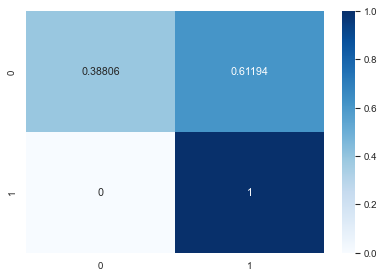

In [195]:
print_stats(lin_refit, lin_refit_predict_train, lin_refit_predict_test)

In [ ]:
%store -r lin_refit

## poly kernel

In [196]:
# Polynomial kernel with Grid Search
param_poly_grid = {'C': loguniform(0.1, 3000), 
                   'degree': range(2, 6), 
                   'gamma': [1,'scale','auto'], 
                   'class_weight' : ['balanced']}
poly_grid = RandomizedSearchCV(SVC(kernel='poly'), 
                               param_poly_grid, 
                               refit='AUC', 
                               n_jobs=8, 
                               return_train_score=True, 
                               scoring=scoring, 
                               cv=stratified_kf, 
                               n_iter=150, 
                               random_state=13)
poly_grid.fit(train_set,train_label)
#Parametri Migliori
print(poly_grid.best_params_)
print(poly_grid.best_score_)

{'C': 1896.9999363581765, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale'}
0.888413661027769


In [197]:
results_poly_df = pd.DataFrame(poly_grid.cv_results_)

In [198]:
results_poly_df[['mean_test_AUC', 'mean_test_Acc']].sort_values('mean_test_Acc', ascending=False).head(10)

,mean_test_AUC,mean_test_Acc
137,0.815863,0.815700
127,0.816087,0.814334
6,0.815640,0.812969
109,0.813868,0.812287
53,0.811331,0.804778
60,0.804532,0.804096
44,0.815113,0.795904
66,0.872582,0.787031
94,0.875104,0.782253
26,0.875040,0.781570


In [270]:
results_poly_df.loc[results_poly_df['mean_test_Acc'] > 0.80, ['mean_test_AUC', 'mean_test_Acc']].sort_values('mean_test_AUC', ascending=False).head(10)

,mean_test_AUC,mean_test_Acc
127,0.816087,0.814334
137,0.815863,0.815700
6,0.815640,0.812969
109,0.813868,0.812287
53,0.811331,0.804778
60,0.804532,0.804096


In [271]:
# poly_refit = SVC(kernel='poly', **(poly_grid.best_params_)).fit(train_set, train_label)
poly_refit = SVC(kernel='poly', **(results_poly_df.loc[137, 'params'])).fit(train_set, train_label)
poly_refit

SVC(C=0.19126004779214548, class_weight='balanced', gamma='auto', kernel='poly')

In [272]:
poly_refit_predict_train = poly_refit.predict(train_set)
poly_refit_predict_test = poly_refit.predict(test_set)

____________________________________________________________
Accuracy train set  0.8013651877133106
Accuracy test set  0.7750511247443763
Precision train set  0.8244382304851952
Recall train set  0.8013651877133106
F1 score train set  0.8106941219092016
____________________________________________________________
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       402
           1       0.43      0.77      0.55        87

    accuracy                           0.78       489
   macro avg       0.68      0.77      0.70       489
weighted avg       0.85      0.78      0.80       489

____________________________________________________________


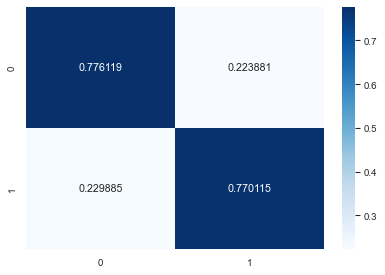

In [273]:
print_stats(poly_refit, poly_refit_predict_train, poly_refit_predict_test)

## RBF kernel

In [228]:
param_rbf_grid = {'C': loguniform(0.1, 3000),
                  'gamma': loguniform(1e-9,1e3) ,
                  'class_weight' : ['balanced']}
rbf_grid = RandomizedSearchCV(SVC(kernel='rbf'),
                              param_rbf_grid,refit='AUC', 
                              n_jobs=8, 
                              return_train_score=True,
                              scoring=scoring,
                              cv=stratified_kf,
                              n_iter= 2000,
                              random_state=13)
rbf_grid.fit(train_set,train_label)

print(rbf_grid.best_params_)
print(rbf_grid.best_score_)

{'C': 22.846327541505858, 'class_weight': 'balanced', 'gamma': 11.152424949920247}
0.8983242898180658


In [229]:
results_rbf_df = pd.DataFrame(rbf_grid.cv_results_)

In [230]:
results_rbf_df[['mean_test_AUC', 'mean_test_Acc']].sort_values('mean_test_Acc', ascending=False).head(10)

,mean_test_AUC,mean_test_Acc
102,0.852841,0.850512
1218,0.855107,0.849147
759,0.857916,0.847782
1255,0.836961,0.847099
1678,0.838509,0.846416
1451,0.844430,0.846416
106,0.853208,0.845734
1418,0.848388,0.845051
404,0.861698,0.845051
1986,0.821258,0.845051


In [252]:
results_rbf_df[['mean_test_AUC', 'mean_test_Acc']].sort_values('mean_test_AUC', ascending=False).head(10)

,mean_test_AUC,mean_test_Acc
905,0.898324,0.789078
1400,0.898133,0.787031
311,0.896968,0.784983
1437,0.896521,0.781570
1307,0.896377,0.797952
767,0.896138,0.781570
1788,0.896026,0.785666
1306,0.895468,0.819795
133,0.895436,0.781570
1843,0.895180,0.808874


In [259]:
rbf_refit = SVC(kernel='rbf', **(results_rbf_df.iloc[905].params)).fit(train_set, train_label)
rbf_refit

SVC(C=22.846327541505858, class_weight='balanced', gamma=11.152424949920247)

In [260]:
rbf_refit_predict_train = rbf_refit.predict(train_set)
rbf_refit_predict_test = rbf_refit.predict(test_set)

____________________________________________________________
Accuracy train set  0.816382252559727
Accuracy test set  0.820040899795501
Precision train set  0.8993997735951069
Recall train set  0.816382252559727
F1 score train set  0.8353956376287888
____________________________________________________________
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       402
           1       0.00      0.00      0.00        87

    accuracy                           0.82       489
   macro avg       0.41      0.50      0.45       489
weighted avg       0.68      0.82      0.74       489

____________________________________________________________


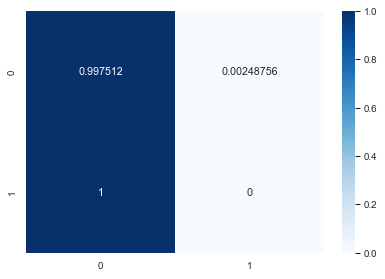

In [261]:
print_stats(rbf_refit, rbf_refit_predict_train, rbf_refit_predict_test)

## Sigmoid kernel

In [274]:
#Sigmoid Kernel Con Grid Search
param_sig_grid = {'C': loguniform(0.1, 3000),
                  'gamma': loguniform(1e-9,1e3), 
                  'class_weight' : ['balanced']}
sig_grid = RandomizedSearchCV(SVC(kernel='sigmoid')
                              ,param_sig_grid,
                              refit="AUC", 
                              return_train_score=True, 
                              n_jobs=8, 
                              scoring=scoring,
                              cv=stratified_kf, 
                              n_iter= 500, 
                              random_state=13)
sig_grid.fit(train_set,train_label)
#Parametri Migliori
print(sig_grid.best_params_)
print(sig_grid.best_score_)

{'C': 1073.1053501782374, 'class_weight': 'balanced', 'gamma': 0.0057921801697604445}
0.8473827002872646


In [242]:
results_sig_df = pd.DataFrame(sig_grid.cv_results_)

In [243]:
results_sig_df[['mean_test_AUC', 'mean_test_Acc']].sort_values('mean_test_Acc', ascending=False).head(10)

,mean_test_AUC,mean_test_Acc
1,0.500000,0.822526
218,0.545021,0.822526
159,0.499314,0.822526
326,0.813996,0.741980
98,0.827306,0.739932
28,0.815847,0.739249
375,0.822694,0.738567
238,0.818225,0.737201
171,0.818050,0.737201
323,0.817587,0.737201


In [262]:
results_sig_df[['mean_test_AUC', 'mean_test_Acc']].sort_values('mean_test_AUC', ascending=False).head(10)

,mean_test_AUC,mean_test_Acc
85,0.847383,0.722867
231,0.847367,0.724915
217,0.847335,0.727645
348,0.847335,0.723549
84,0.847335,0.725597
288,0.847287,0.726962
178,0.846968,0.726280
249,0.846952,0.721502
422,0.846872,0.724915
496,0.846824,0.710580


In [263]:
sig_refit = SVC(kernel='sigmoid', **(results_sig_df.iloc[85].params)).fit(train_set, train_label)

In [264]:
sig_refit_predict_train = sig_refit.predict(train_set)
sig_refit_predict_test = sig_refit.predict(test_set)

____________________________________________________________
Accuracy train set  0.7249146757679181
Accuracy test set  0.49693251533742333
Precision train set  0.8467173004609342
Recall train set  0.7249146757679181
F1 score train set  0.7560106097781748
____________________________________________________________
              precision    recall  f1-score   support

           0       0.99      0.39      0.56       402
           1       0.26      0.99      0.41        87

    accuracy                           0.50       489
   macro avg       0.63      0.69      0.49       489
weighted avg       0.86      0.50      0.53       489

____________________________________________________________


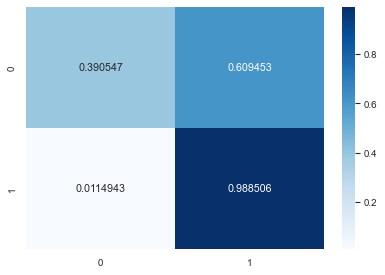

In [265]:
print_stats(sig_refit, sig_refit_predict_train, sig_refit_predict_test)

## ROC Curve

In [ ]:
from sklearn import metrics

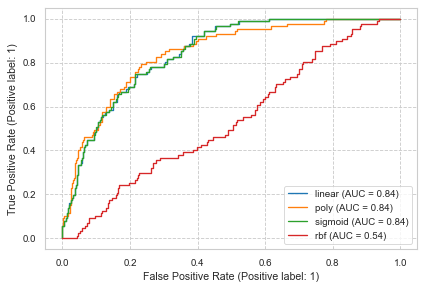

In [279]:
ax = plt.gca()
RocCurveDisplay.from_estimator(lin_refit, test_set, test_label, ax=ax, name='linear')
RocCurveDisplay.from_estimator(poly_refit, test_set, test_label, ax=ax, name='poly')
RocCurveDisplay.from_estimator(sig_refit, test_set, test_label, ax=ax, name='sigmoid')
RocCurveDisplay.from_estimator(rbf_refit, test_set, test_label, ax=ax, name='rbf')
plt.show()

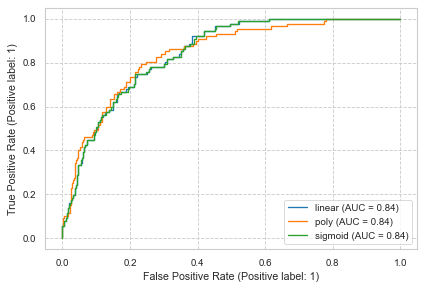

In [280]:
ax = plt.gca()
RocCurveDisplay.from_estimator(lin_refit, test_set, test_label, ax=ax, name='linear')
RocCurveDisplay.from_estimator(poly_refit, test_set, test_label, ax=ax, name='poly')
RocCurveDisplay.from_estimator(sig_refit, test_set, test_label, ax=ax, name='sigmoid')
plt.show()

In [283]:
import pickle

with open('linear_svm.pickle', 'wb') as handle:
    pickle.dump(lin_refit, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('poly_svm.pickle', 'wb') as handle:
    pickle.dump(lin_refit, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('sig_svm.pickle', 'wb') as handle:
    pickle.dump(sig_refit, handle, protocol=pickle.HIGHEST_PROTOCOL)